# Notebook with CVAE model and conditionning over day of the week, month and temperature

## Loading Libraries 

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats


In [2]:
#paths in git

#root git folder 
path_main_folder = '/home/marotant/dev/Autoencoder_Embedding_Expert_Caracteristion_'

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [3]:
#import class and methods from src
from keras import backend as K
from CVAE.callbacks import NEpochLogger,callbackWeightLoss
#from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE, CVAE_emb, CAE
from conso.load_shape_data import *  

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [4]:
#directories to store trained model and the related projector

log_dir_projector=path_main_folder+"/notebooks/logs/Expe3/CVAE_W_M_T/projector"
log_dir_model=path_main_folder+"/notebooks/logs/Expe3/CVAE_W_M_T//model"
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)

# Table of contents:
- Load Data
- Make Training Set
- Define and Train Model
- Build Projector
- Compute Feature Scores in latent space
- Study reconstruction Error
- Study Holidays prediction
- Detect atypical events
- Conclusion

# Load dataset 

In [5]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data')
dataset_csv = os.path.join(path_data, "dataset.csv")
x_conso = pd.read_csv(dataset_csv, sep=",",)
x_conso.ds = pd.to_datetime(x_conso.ds)

In [6]:
#drop indices column
x_conso=x_conso.drop(columns=x_conso.columns[0],axis=1)


In [7]:
#Visualize data frame head
x_conso.head(5)

,ds,consumption_France,temperature_France,is_holiday_day
0,2012-12-28 00:00:00,59679.0,8.817600,0.0
1,2012-12-28 00:30:00,58103.0,8.690875,0.0
2,2012-12-28 01:00:00,55354.0,8.564150,0.0
3,2012-12-28 01:30:00,55196.0,8.440525,0.0
4,2012-12-28 02:00:00,54324.0,8.316900,0.0


# Make training set of daily electrical consumption profiles and conditions 
In this experiment there is no condition to pass. This is not something we can do with a PCA anyway

In [8]:
name_set_plot = 'train'
version = '-v1'
nPoints=1830

In [9]:
dict_xconso = {'train': x_conso}

In [10]:
# Normalize input variables
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption_France']


Give the features on which to condition

In [11]:
type_x = ['conso']
type_cond = ['day','month','temperature']
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, type_cond=type_cond)

/home/marotant/dev/Autoencoder_Embedding_Expert_Caracteristion_/src/conso/load_shape_data.py:212: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/marotant/dev/Autoencoder_Embedding_Expert_Caracteristion_/src/conso/load_shape_data.py:215: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



(1830, 67)


/home/marotant/dev/Autoencoder_Embedding_Expert_Caracteristion_/src/conso/load_shape_data.py:322: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/marotant/dev/Autoencoder_Embedding_Expert_Caracteristion_/src/conso/load_shape_data.py:328: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [12]:

nPoints=dataset['train']['x'][1].shape[0]

#get conditions in array
days_emb =dataset['train']['x'][1][:,0:7]
month_emb =dataset['train']['x'][1][:,7:19]
temp_emb=dataset['train']['x'][1][:,19:]
to_emb=dataset['train']['x'][1]

x = dataset['train']['x'][0]

dataset['train']['x'] = [x,days_emb,month_emb,temp_emb]

In [13]:
np.shape(temp_emb)

(1830, 48)

In [14]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0

# Build and train model CVAE

In [15]:
#on sauvegarde le dataset
path_out = log_dir_model

In [16]:
# Parameters for autoencoder
e_dims=[48,35,24,12]#encoder dim
d_dims=[48,35,24,12]#decoder dim. Dense Blocks in skip connections can make the dimensions bigger when layers are concatenated with the previous one
to_emb_dim=[7,12,48] #input dimensions for conditions
cond_pre_dim = 0
input_dim = dataset['train']['x'][0].shape[1]
z_dim= 4
lambda_val = 0.5 #hyper-parameter which value was selected after cross-validation

In [17]:
name_model = 'cvae_conso-W_M_T_30min-journalier'
#name_model = 'cvae_classification'

In [18]:
#if needs to relaod model classes after modification wothout restarting the kernel

import CVAE.cvae_model
import CVAE.callbacks
import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.callbacks)

%load_ext autoreload
%autoreload

In [19]:
Lambda = K.variable(lambda_val, dtype='float32')
model = CVAE.cvae_model.CVAE_emb(input_dim=input_dim,
                  e_dims=e_dims, 
                  d_dims=d_dims, 
                  cond_pre_dim=cond_pre_dim,
                  z_dim=z_dim, 
                  beta=Lambda,
                  name=name_model, 
                  output=path_out,
                 to_emb_dim=to_emb_dim,
                 emb_dims=[[5,3],[6,3],[12,4]], emb_to_z_dim=[5,5],is_L2_Loss=False,has_BN=2)#these dimensions define the dimension layer of the conitional network

Instructions for updating:
Colocations handled automatically by placer.
5
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 7)            0                                            
__________________________________________________________________________________________________
emb_input_1 (InputLayer)        (None, 12)           0                                            
__________________________________________________________________________________________________
emb_input_2 (InputLayer)        (None, 48)           0                                            
__________________________________________________________________________________________________
x_true (InputLayer)             (None, 48)           0                                            
____

### Trainning model 

In [20]:
from keras.callbacks import TensorBoard
from time import time

#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)


We start a pre-training phase with a constant and high lambda to properly learn the conditional embedding



--- START TRAINING ---

Instructions for updating:
Use tf.cast instead.
emb_input_0
emb_input_1
emb_input_2
[2318.4988  831.5785 1996.5227 1582.0393]
4.313096375
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.870339  0.448841  0.503484        0.185455     0.854591
random model    0.479205  0.152051  0.078313        0.025455    -0.421012
0 Epochs ...  - loss: 29.5450 - decoder_loss: 28.3549 - decoder_for_kl_loss: 2.3803 - val_loss: 16.3492 - val_decoder_loss: 14.3991 - val_decoder_for_kl_loss: 3.9003 val_loss 16.349243831113387 ... lambda Loss 0.5
emb_input_0
emb_input_1
emb_input_2
[1477.8396    75.7572    74.55479 1102.7085 ]
10.74925102083333
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.950702  0.491906  0.248736        0.232727     0.104042
random model    0.485197  0.127896  0.073626        0.018182    -0.416029
100 Epochs ...  - loss: 4.5526 - decoder_loss: 2.8703 - decoder_for_kl_loss: 3

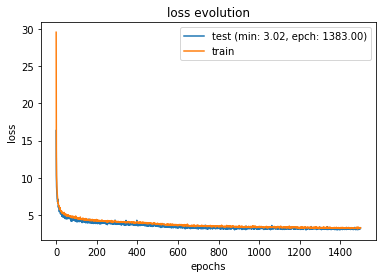

In [21]:
#model.main_train(dataset, training_epochs=200, batch_size=20, verbose=False,callbacks=[tensorboard])
import warnings
warnings.filterwarnings('ignore')

lambda_decreaseRate=0.0
lambda_min=0.01 #p

out_batch = NEpochLogger(x_train_data=dataset['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
weightLoss=callbackWeightLoss(lambda_val,lambda_decreaseRate,lambda_min)
#model.main_train(dataset, training_epochs=1500, batch_size=40, verbose=False,callbacks=[tensorboard,out_batch])#,weightLoss])
model.main_train(dataset, training_epochs=1500, batch_size=32, verbose=0,callbacks=[tensorboard,out_batch],validation_split=0.1)

#visualizer = LatentSpaceVisualizer(model_folder_path=model_path, dataset_path=labellisation_data_folder + 'sequences_dataset/sequences_et_labels.npz')
 #   visualizer.visualize_embedding_after_training()

We now continue with a learning phase for better reconstruction and refine the similarities between instances. It can be seen as a diffusion phase. We smoothly decese the lambda after each epoch.



--- START TRAINING ---

emb_input_0
emb_input_1
emb_input_2
[1146.362      25.163239    9.220108  447.91772 ]
11.297619010416664
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.584839  0.179838  0.149764        0.738182    -0.036715
random model    0.495115  0.156338  0.091955        0.018182    -0.400652
0 Epochs ...  - loss: 3.2127 - decoder_loss: 2.1178 - decoder_for_kl_loss: 2.1898 - val_loss: 3.0941 - val_decoder_loss: 2.0734 - val_decoder_for_kl_loss: 2.0412 val_loss 3.094051663341418 ... lambda Loss 0.5
emb_input_0
emb_input_1
emb_input_2
[1128.1299     15.450474   13.243797  400.57687 ]
11.650445083333333
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.599186  0.192227  0.141063        0.763636    -0.072673
random model    0.496691  0.145349  0.084860        0.043636    -0.423003
100 Epochs ...  - loss: 2.9915 - decoder_loss: 2.0218 - decoder_for_kl_loss: 2.1433 - val_loss: 3.0115 - val_de

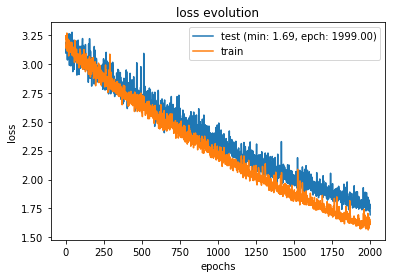

In [22]:
lambda_decreaseRate=0.001 #parameter by default
weightLoss=callbackWeightLoss(lambda_val,lambda_decreaseRate,lambda_min)
#model.main_train(dataset, training_epochs=1500, batch_size=40, verbose=False,callbacks=[tensorboard,out_batch])#,weightLoss])
model.main_train(dataset, training_epochs=2000, batch_size=40, verbose=0,callbacks=[tensorboard,out_batch,weightLoss],validation_split=0.1)

#visualizer = LatentSpaceVisualizer(model_folder_path=model_path, dataset_path=labellisation_data_folder + 'sequences_dataset/sequences_et_labels.npz')
 #   visualizer.visualize_embedding_after_training()

DimsImportance=[1394.4407  1343.6127    44.23878 1616.7899 ] Only 3 dimensions are significant here (each term is the sum of absolute values in each direction for the all the datapoints.
There is no significant overfitting when comparing training error to validation error. This will be confimed later on specific examples.

In [23]:
with open(os.path.join(path_out,name_model,"config.txt"),'w') as file: 
    file.write(str(cond_pre_dim) + '\n')
    #file.write(str(emb_dims) + '\n')
    file.write(str(e_dims) + '\n') 
    file.write(str(d_dims) + '\n') 
    file.write(str(z_dim) + '\n')
    file.write(str(Lambda) + '\n')

In [24]:
#sauvegarde du dataset associé
name_dataset = 'dataset.pickle'

with open( os.path.join(path_out,name_model, name_dataset), "wb" ) as file:
    pickle.dump( dataset, file )

## Loading model 

In [25]:
model.load_model(os.path.join(path_out, name_model, 'models'))

In [26]:
emb_inputs=[days_emb,month_emb,temp_emb]
emb_ouputs = model.embedding_enc.predict(emb_inputs)

#cond_pre=day_emb
#cond = np.concatenate((cond_pre, emb_ouputs), axis=1)
cond  = emb_ouputs
x_input = dataset['train']['x'][0]

input_encoder = [x_input,cond]

In [27]:
x_encoded = model.encoder.predict(input_encoder)[0]
x_hat = model.cvae.predict(x=dataset['train']['x'])[0]

# Analysis of the latent space with the construction of a tensorboard projector

In [28]:

nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
import os,cv2
x_encoded_reduced=x_encoded[0:nPoints,]
images=createLoadProfileImages(x,x_hat,nPoints)

<Figure size 432x288 with 0 Axes>

In [29]:

sprites=images_to_sprite(images)
cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)

True

In [30]:

writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)

In [31]:
log_dir_projector

'/home/marotant/dev/Autoencoder_Embedding_Expert_Caracteristion_/notebooks/logs/Expe3/CVAE_W_M_T/projector'

# Predict Features in latent space

In [32]:
df_noCond_VAE=predictFeaturesInLatentSPace(x_conso,calendar_info,x_encoded)

12.219337010416663
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.590781  0.189577  0.143480        0.745455    -0.200984
random model    0.504077  0.132812  0.077557        0.036364    -0.395000


# reconstruction error analysis

In [33]:
error=np.sum(np.abs((x - x_hat)),axis=1)/48

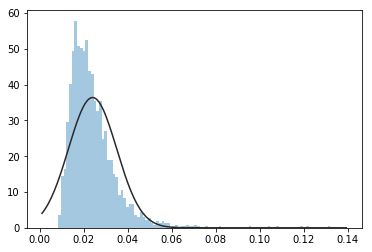

In [34]:
#make a histogram over residuals
import seaborn as sn
sn.distplot(error, kde=False, fit=stats.norm, bins=100)

Check the day with errors above a threshold

In [35]:
ErrorThreshold=0.08
idxMaxError=[i for i in range(0,nPoints) if error[i]>=ErrorThreshold]
calender_error=calendar_info.loc[idxMaxError]
calender_error['error']=error[idxMaxError]

calender_error

,ds,month,weekday,is_weekday,is_holiday_day,error
93,2013-03-31,3,6,0,0.0,0.107987
821,2015-03-29,3,6,0,0.0,0.081488
1465,2017-01-01,1,6,0,1.0,0.095784
1466,2017-01-02,1,0,1,0.0,0.122136


Check the first n days with highest errors 

In [36]:
nDays=30

decreasingOrderIdx=np.argsort(-error)
calendar_Error_Highest=calendar_info.loc[decreasingOrderIdx[0:nDays]]
calendar_Error_Highest['error']=error[decreasingOrderIdx[0:nDays]]
calendar_Error_Highest

,ds,month,weekday,is_weekday,is_holiday_day,error
1825,2017-12-27,12,2,1,0.0,0.132155
1466,2017-01-02,1,0,1,0.0,0.122136
1827,2017-12-29,12,4,1,0.0,0.118759
93,2013-03-31,3,6,0,0.0,0.107987
1822,2017-12-24,12,6,0,0.0,0.104441
1465,2017-01-01,1,6,0,1.0,0.095784
821,2015-03-29,3,6,0,0.0,0.081488
1457,2016-12-24,12,5,0,0.0,0.075975
1160,2016-03-02,3,2,1,0.0,0.072095
5,2013-01-02,1,2,1,0.0,0.071253


Visualize the reconstruction error over a specific day

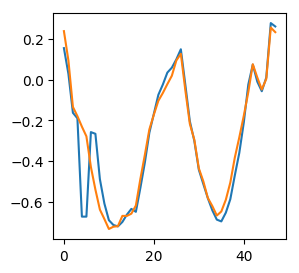

In [37]:
indice=1185 #1185 is the changing hour day end of march
fig = plt.figure(dpi=100,figsize=(3,3))
#set(gca,'Color','k')
plt.plot(x[indice,:])
plt.plot(x_hat[indice,:])

Visualize the reconstruction error over the days with highest error

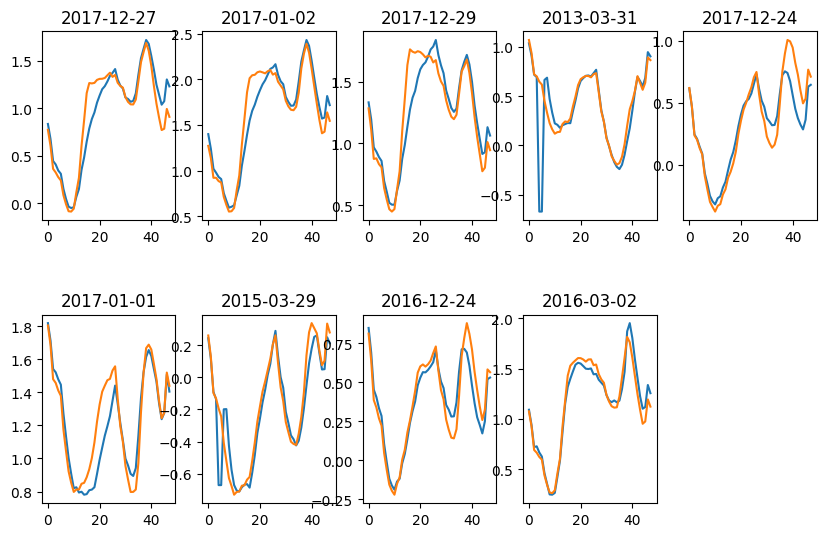

In [38]:
nPlots=10#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,10))
for i in range(1, nPlots):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=decreasingOrderIdx[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_Error_Highest.ds.dt.date.iloc[i-1])

2013-03-31 is the day with a missing hour because of changing day time and the consumption value is set to 0. It is hence normal that it is not well predicted and a good indicator that the model does not tend to overfit.

# Study of holiday predictions

In [39]:
#preparation des features d'interet
yHd=calendar_info['is_holiday_day'].astype(int)
indicesHd=np.array([i for i in range(0, nPoints) if yHd[i] == 1])
yHd_only=yHd[yHd==1]
x_encoded_Hd=x_encoded[indicesHd,]

In [40]:
results_hd=scoreKnnResults(x_encoded,yHd,type='classifier',k=5,cv=10)



## holidays well predicted and not

In [41]:
results_hd_only=[results_hd['predP'][i] for i in indicesHd ]
indices_Hd_predict=[i for i in indicesHd if  results_hd['predP'][i]>=0.5]
indices_Hd_not_predicted=[i for i in indicesHd if  results_hd['predP'][i]<0.5]
calendar_info.loc[indices_Hd_predict]

,ds,month,weekday,is_weekday,is_holiday_day
4,2013-01-01,1,1,1,1.0
124,2013-05-01,5,2,1,1.0
131,2013-05-08,5,2,1,1.0
132,2013-05-09,5,3,1,1.0
143,2013-05-20,5,0,1,1.0
230,2013-08-15,8,3,1,1.0
318,2013-11-11,11,0,1,1.0
362,2013-12-25,12,2,1,1.0
369,2014-01-01,1,2,1,1.0
479,2014-04-21,4,0,1,1.0


In [42]:
len(indices_Hd_predict)


34

In [43]:

calendar_info.loc[indices_Hd_not_predicted]

,ds,month,weekday,is_weekday,is_holiday_day
94,2013-04-01,4,0,1,1.0
198,2013-07-14,7,6,0,1.0
308,2013-11-01,11,4,1,1.0
496,2014-05-08,5,3,1,1.0
673,2014-11-01,11,5,0,1.0
861,2015-05-08,5,4,1,1.0
1038,2015-11-01,11,6,0,1.0
1220,2016-05-01,5,6,0,1.0
1227,2016-05-08,5,6,0,1.0
1458,2016-12-25,12,6,0,1.0


In [55]:
len(results_hd_only_NotPredicted)

11

Days not predicted are mostly days on weekends except for 2013-11-01, 2015-05-08, 2014-05-08 and 2013-04-01 which are similar to some holidays but also to non-working days. They could hence be predicted as non-working days which is fine

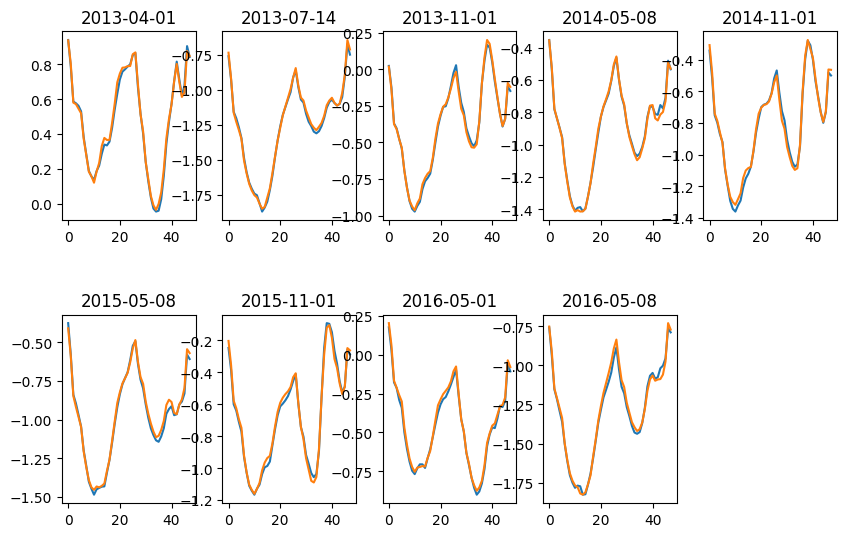

In [56]:
nPlots=10#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,10))
for i in range(1, nPlots):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=indices_Hd_not_predicted[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_info.ds.dt.date.iloc[indice])

# Detect Events as local outliers

<function matplotlib.pyplot.show(*args, **kw)>

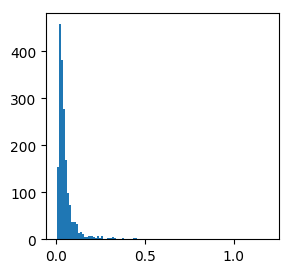

In [65]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(10)
neigh.fit(x_encoded)

[distance_knn,kneighbors]=neigh.kneighbors(x_encoded, 2, return_distance=True)
nearest=distance_knn[:,1]
fig = plt.figure(dpi=100,figsize=(3,3))
plt.hist(nearest,bins=100)
plt.show

In [66]:
from scipy import stats

stats.describe(nearest)

DescribeResult(nobs=1830, minmax=(0.002066032360427631, 1.1948393669811612), mean=0.05158065464930297, variance=0.004200303640771685, skewness=6.516391073387694, kurtosis=73.90740199324071)

<function matplotlib.pyplot.show(*args, **kw)>

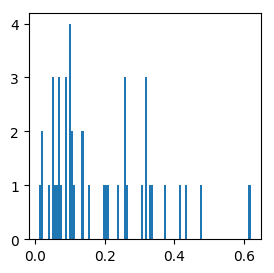

In [67]:
fig = plt.figure(dpi=100,figsize=(3,3))
plt.hist(nearest[indicesHd],bins=100)
plt.show

In [68]:
stats.describe(nearest[indicesHd])

DescribeResult(nobs=45, minmax=(0.011622080323431544, 0.6193157734187748), mean=0.18221366145957785, variance=0.019930604961484286, skewness=1.014639841800361, kurtosis=0.4696847086965099)

In [72]:
calendar_info.loc[np.where(nearest>=0.35)]

,ds,month,weekday,is_weekday,is_holiday_day
73,2013-03-11,3,0,1,0.0
94,2013-04-01,4,0,1,1.0
107,2013-04-14,4,6,0,0.0
369,2014-01-01,1,2,1,1.0
405,2014-02-06,2,3,1,0.0
727,2014-12-25,12,3,1,1.0
1458,2016-12-25,12,6,0,1.0
1465,2017-01-01,1,6,0,1.0
1490,2017-01-26,1,3,1,0.0
1491,2017-01-27,1,4,1,0.0


2013-01-11 and 2017-01-26 were big snowy events in France. 2013-04-14 was a punctual summer day in early spring. 2014-02-06 was a stormy day. Other days are either holidays or similar non-working days which can be analysed in the projector.

In [62]:
indicesNear=[i for i in range(0,len(nearest)) if nearest[i]>=1]
nearest[np.where(nearest>=1)]

array([1.25988775, 1.27261021, 1.1080642 , 1.06376521, 1.14850269,
       1.29555307, 1.14698442, 1.14429475, 1.14429475, 1.19970635])

<bound method Figure.show of <Figure size 1000x1000 with 10 Axes>>

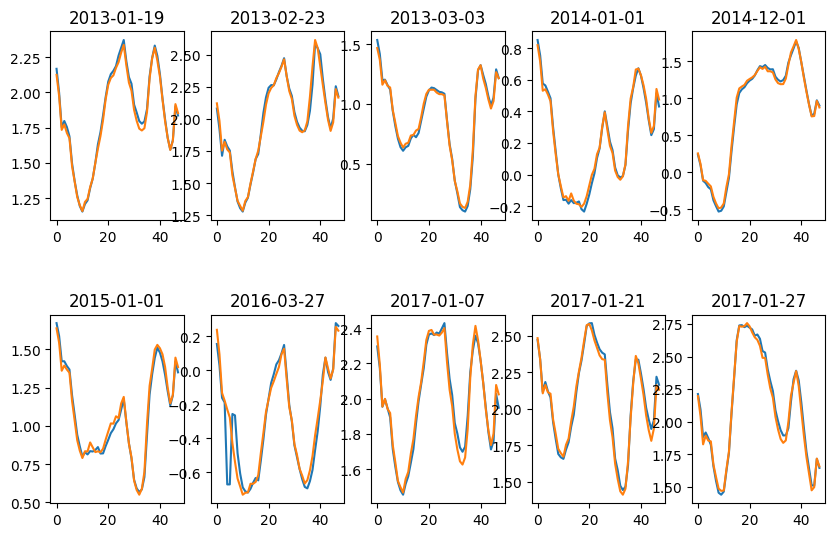

In [63]:
nPlots=len(indicesNear)#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,10))
for i in range(1, nPlots+1):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=indicesNear[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_info.ds.dt.date.iloc[indice])
fig.show

# Conclusions
- We managed to properly condition on the expert feature passed as the residual latent space is almost independant from them
- We recover holidays which are well-represented and can be predicted
- We can use the latent projection to discover other non-owrking days to label such as days near holidays or Christmas week
- When looking at local outliers, we discover first weather events to further analyze in a more appropriate conditional representation were they are better represented.


